Warunki brzegowe:
* Dirichleta: u = 0
* Neumanna: $\frac{\partial{u}}{\partial{n}} = g$

$g = r^\frac{2}{3} \cdot \sin^\frac{2}{3}(\theta + \frac{\pi}{2})$ - współrzędne biegunowe

Można tę funkcję zapisać również we współrzędnych kartezjańskich
$g = \sqrt[3]{x^2}$

Sformułowanie wariacyjne:  
$B(\phi_i, \phi_j) = l(\phi_j)$  
$B(\phi_i, \phi_j) = \int_\Omega \frac{\partial{\phi_i}}{\partial{x_1}} \cdot \frac{\partial{\phi_j}}{\partial{x_1}} + \frac{\partial{\phi_i}}{\partial{x_2}} \cdot \frac{\partial{\phi_i}}{\partial{x_2}} dx$

Zapis B można przekształcić do postaci  
$B(\phi_i, \phi_j) = \frac{1}{4} \left ( \frac{h}{w} sgn_x(i) sgn_(j) + \frac{w}{h} sgn_y(i) sgn_y(j) \right )$  
gdzie $sgn$ to funckje określająca znak wyrazu zależnie od $i$ bądź $j$:
$$
sgn_x(i) = 
\begin{cases}
       -1& \quad i = 0, 3 \\
       1& \quad i = 1, 2
     \end{cases}\\
     sgn_y(i) = 
\begin{cases}
       -1& \quad i = 0, 1 \\
       1& \quad i = 2, 3
     \end{cases}
     $$
     
Funkcjonał $l$ z prawej strony równości rozważamy na krawędziach, opierając się na współrędnych $x_0$ i $y_0$ ich środków.
Niech w oznacza długość krawędzi, wówczas:

$ l(\phi_j) \approx g(x_0,y_0) \phi_j(x_0,y_0) \cdot w$


In [391]:
import math
from math import sin, floor
from fractions import Fraction as Frac
import numpy as np
import matplotlib.pyplot as plt

def g(x, y):
    return (x**2)**(1/3)

MAX_COORD = 1.0
WIDTH = MAX_COORD * 2
center = np.array([0,0])

n = 20*2 # 2x2 - basic case 
width = WIDTH / n # width of one element
idxs = range(0, n*n)
corner = center + [-WIDTH / 2, +WIDTH/2]

In [392]:
# arrays of interesting "points" - between elements

p_dim = n + 1

# this will be the base functions e_i
es = np.zeros((p_dim, p_dim))

Do obliczania funkcji w dowolnym punkcie konieczne jest wyznaczenie funkcji kształtu.

Niech $x_0$, $y_0$ będą współrzędnymi lewewgo dolnego narożnika danego elementu skończonego, a $w$ i $h$ jego szerkoośćią i wysokością. Można wówczas wyznaczyć następujące funkcje:
* $\phi_0 = \left(1 - \frac{x - x_0}{w}\right) \left(1 - \frac{y - y_0}{h}\right)$
* $\phi_1 = \left(\frac{x - x_0}{w}\right) \left(1 - \frac{y - y_0}{h}\right)$
* $\phi_2 = \left(\frac{x - x_0}{w}\right) \left(\frac{y - y_0}{h}\right)$
* $\phi_3 = \left(1 - \frac{x - x_0}{w}\right) \left(\frac{y - y_0}{h}\right)$

Ich złożenia pozwolą wyznaczyć funkcje $e_i$ na przecięciach elementów skończonych.

In [393]:

# local functions for given element
def phis(elem_idx):
    x0, y0 = coords(elem_idx)
    
    if(x0 < 0 and y0 < 0): 
        return [lambda x,y: 0]*4
    else:
        return [
            lambda x, y: (1 - (x - x0)/width) * (1 - (y - y0)/width),
            lambda x, y: ((x - x0)/width) * (1 - (y - y0)/width),
            lambda x, y: ((x - x0)/width) * ((y - y0)/width),
            lambda x, y: (1 - (x - x0)/width) * ((y - y0)/width)
        ]

In [394]:


def is_on_border(x, y):
    return math.isclose(abs(center[0]+MAX_COORD), x, rel_tol=1e-07) \
        or math.isclose(abs(center[1]+MAX_COORD), y, rel_tol=1e-07)

# coordinates of lower left corner of given element
def coords(elem_idx):
    row = elem_idx // n
    col = elem_idx % n
    return corner + [col * width, - (row + 1) * width]

# coordinates of all corners of given element
def corners(elem_idx):
    c = coords(elem_idx)
    return [c, c + [width, 0], c + [width, width], c + [0, width]]

# middles of element edges
def middles(elem_idx):
    c = coords(elem_idx)
    return [c + [width / 2, 0], c + [width, width / 2], c + [0, width / 2], c + [width/2, width]]

# middless of edges of element defined by neumann edge
def neumann_coords(elem_idx):
    return list(
        filter(lambda c: is_on_border(*c),
               [tuple(c) for c in middles(elem_idx)])
    )

# element corner to point coords in a matrix
# corners are indexed counterclockwise
def corner_to_point(elem_idx, corner_idx):
    row = elem_idx // n
    col = elem_idx % n
    if corner_idx == 0:
        return (row + 1, col)
    elif corner_idx == 1:
        return (row + 1, col + 1)
    elif corner_idx == 2:
        return (row, col + 1)
    elif corner_idx == 3:
        return (row, col)
    
# matrix point coords to linear point index
def point_to_pidx(x, y):
    return x * p_dim + y

# matrix point coords to point index
def corner_to_pidx(elem_idx, i):
    return point_to_pidx(*corner_to_point(elem_idx, i))

# sgn_x and sgn_y for given phi function id
def corner_to_factors(i):
    return {0: (-1, -1),
            1: (1, -1),
            2: (1, 1),
            3: (-1, 1)}[i]    

    
# find idx of element containing given point
def in_which(x, y):
    col = min(floor((x - (0 - MAX_COORD)) / width), n-1)
    row = min(floor((MAX_COORD - y) / width), n-1)
    return row * n + col


## Wektor prawej strony
Podany już wcześniej wzór zostaje wykorzystany poniżej do wyznaczenia kolejnych wartości wektora.  
$ l(\phi_j) \approx g(x_0,y_0) \phi_j(x_0,y_0) \cdot w$

In [395]:
es = np.zeros((p_dim, p_dim))
for elem_idx in idxs:
    for (x,y) in neumann_coords(elem_idx):
        for i, phi in zip(range(0,4), phis(elem_idx)):
            es[corner_to_point(elem_idx, i)] += phi(x, y) * g(x, y) * (width)

In [396]:
# zero out Dirichlet edge and part of matrix not included in the Omega
es[n//2 : n + 1, 0 : n//2 + 1] = 0

#for row in range(n//2, n + 1):
#    for co in range(0, n//2 + 1):
#        es[row, co] = 0

In [397]:
# one dimensional array for use in equations system
L = es.reshape((es.size, 1))

## Wyrazy macierzy sztywności
Wyrazy macierzy sztywności opisuje przytoczony wcześniej wzór  
$$B(\phi_i, \phi_j) = \frac{1}{4} \left ( \frac{h}{w} sgn_x(i) sgn_(j) + \frac{w}{h} sgn_y(i) sgn_y(j) \right )$$



In [398]:
# left side of the equations system
B = np.zeros((p_dim*p_dim, p_dim*p_dim))
for elem_idx in idxs:
    
    # consider every pair of corners
    for i,j in [(x, y) for x in range(0,4) for y in range(0,4)]:
        ip = corner_to_pidx(elem_idx, i)
        jp = corner_to_pidx(elem_idx, j)
        sgnxi, sgnyi = corner_to_factors(i)
        sgnxj, sgnyj = corner_to_factors(j)
        
        B[ip, jp] += 1/4 * (sgnxi * sgnxj + sgnyi * sgnyj)
            
# zero out elements in lower left corner - outside Ω
for row in range(n//2, n + 1):
    for co in range(0, n//2 + 1):
        pidx = point_to_pidx(row, co)
        B[pidx,:] = 0
        B[pidx,pidx]=1
        L[pidx] = 0
        

In [399]:
solution = np.linalg.solve(B, L)


In [400]:
res = n if n > 5 else 50
#res=40

xs = np.linspace(-1,1,res)
ys = np.linspace(-1,1,res)

values = np.zeros((len(xs),len(ys)))

for (i,x) in enumerate(xs):
    for (j,y) in enumerate(ys):
        elem_idx = in_which(x, y)
        
        for corn in range(0, 4):
            pidx = corner_to_pidx(elem_idx, corn)
            phi = phis(elem_idx)[corn]
            
            values[i, j] += solution[pidx] * phi(x, y)


array([[ 1.205,  1.213,  1.208, ...,  2.081,  2.14 ,  2.175],
       [ 1.16 ,  1.154,  1.163, ...,  2.041,  2.074,  2.136],
       [ 1.1  ,  1.107,  1.103, ...,  1.975,  2.032,  2.066],
       ..., 
       [ 0.   ,  0.   ,  0.   , ...,  0.872,  0.924,  0.965],
       [ 0.   ,  0.   ,  0.   , ...,  0.879,  0.92 ,  0.975],
       [ 0.   ,  0.   ,  0.   , ...,  0.873,  0.927,  0.97 ]])

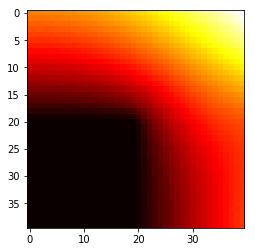

In [401]:
np.set_printoptions(precision=3)
display(np.flipud(values))

plt.imshow(np.flipud(values), cmap='hot', interpolation='nearest')
plt.show()

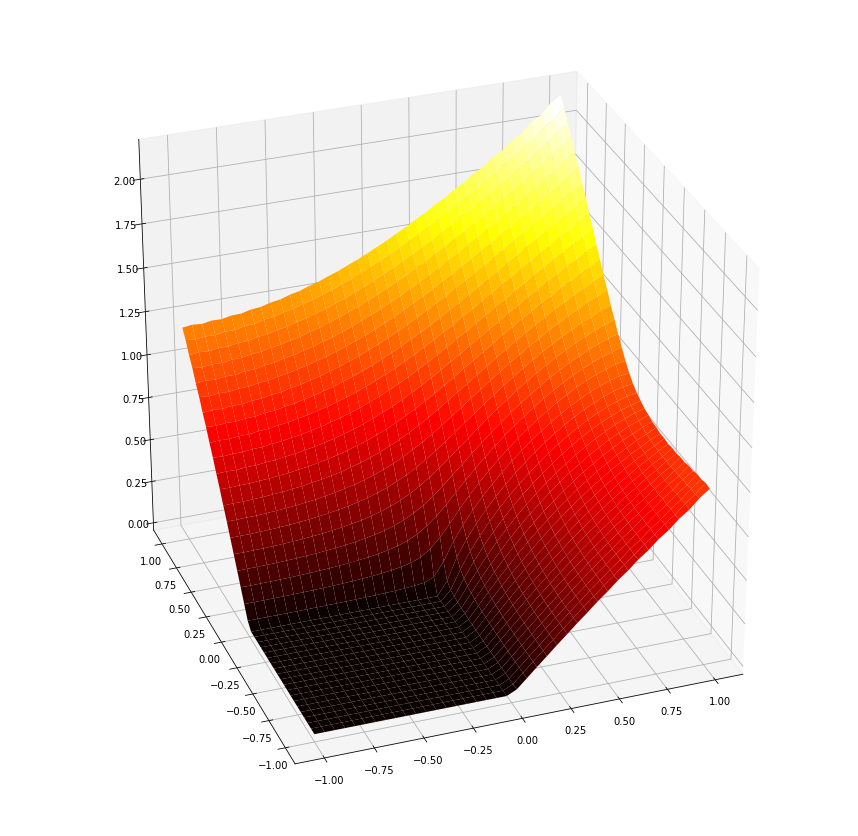

In [402]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

X,Y = np.meshgrid(xs,ys)
ax.plot_surface(X,Y,values, rstride=1, cstride=1, cmap=plt.get_cmap('hot'))
ax.view_init(30, -110)

plt.show()

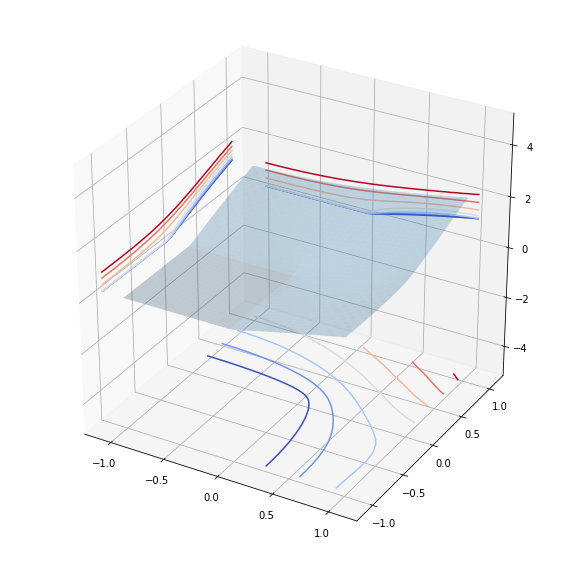

In [403]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_surface(X, Y, values,alpha=0.25)
cset = ax.contour(X, Y, values, zdir='z', offset=-5, cmap='coolwarm')
cset = ax.contour(X, Y, values, zdir='x', offset=-1.2, cmap='coolwarm')
cset = ax.contour(X, Y, values, zdir='y', offset=1.2, cmap='coolwarm')

ax.set_xlim3d(-1.2, 1.2);
ax.set_ylim3d(-1.2, 1.2);
ax.set_zlim3d(-5, 5);
plt.show()